## Group 1
* Huỳnh Tiến Dũng
* Nguyễn Thanh Bảo Danh
* Nguyễn Tư Thành Nhân

# Santander Customer Transaction Prediction EDA 

# Outline

- ### <a href='#1'>1. Problem defining</a>
- ### <a href='#2'>2. Data collecting </a>  
- ### <a href='#3'>3. Khai phá dữ liệu (EDA) </a>
    * #### <a href='#3.1'>3.1. Tổng quan về dữ liệu</a>
    * #### <a href='#3.2'>3.2. Phân tích từng trường dữ liệu </a> 
    * #### <a href='#3.3'>3.3. Phân tích correlation giữa các trường dữ liệu </a> 
- ### <a href='#4'>4. Feature selection and Model building</a>
    * #### <a href='#4.1'>4.1. A Basic Model</a>
    * #### <a href='#4.2'>4.2. Một số thử nghiệm để cải tiến model</a>

# <a id='1'>1. Problem defining

Bài toán có đầu vào là dữ liệu số của 200 features của các khách hàng (đã được ẩn danh và có tên từ val_0 -> val_199), chúng ta cần dựa vào các chỉ số đó để dự đoán xem khách hàng nào sẽ mua hàng. Với mỗi khách hàng dự đoán 0 nếu không mua hàng và 1 nếu mua hàng.

Các trường dữ liệu:

1 - ID_code - Thứ tự của khách hàng - string

2 - val_0 - numerical

...

201 - val_199 - numerical

Output variable:
202 - target - Dự đoán mua / không mua của khách hàng - binary 0/1 


Chúng ta sẽ sử dụng mô hình học máy để dự đoán 0 / 1 cho từng khách hàng. 

Ta sẽ dùng metric ROC AUC score để đánh giá sự hiệu quả của mô hình học máy, có thể sử dụng thêm confusion matrix, F1-Score để có cái nhìn tổng quan hơn.

# <a id='2'>2. Data collecting

Bài toán này ta đã có sẵn 3 tập data dưới dạng file csv từ <a href='https://www.kaggle.com/c/santander-customer-transaction-prediction/data?select=train.csv'>Kaggle Santander Customer Transaction Prediction </a>, là train.csv, test.csv, sample_submission.csv (lần lượt là tập train, tập test và tập chấm mẫu cho mô hình học máy của ta).

#### Import các thư viện cần thiết

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

#### Load data

In [ ]:
train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

# <a id='3'> 3. Khai phá dữ liệu (EDA)

## <a id='3.1'> 3.1. Tổng quan về dữ liệu

In [ ]:
print("Kích thước tập train: {}".format(train_df.shape))
print("Kích thước tập test: {}".format(test_df.shape))

In [ ]:
train_df.head()

In [ ]:
test_df.head()

Tập train gồm: 
* **ID_code** (string)
* **target** (0 / 1)
* **200** trường dữ liệu số, đặt tên bắt đầu từ **var_0** đến **var_199**

Tập test gồm: 
* **ID_code** (string)
* **200** trường dữ liệu số, đặt tên bắt đầu từ **var_0** đến **var_199**

Ta hãy cùng kiểm tra các kiểu dữ liệu và xem có dữ liệu thiếu (NaN / NULL) nào không.

In [ ]:
train_df.isnull().any().any()
# Tập train không có dữ liệu thiếu

In [ ]:
test_df.isnull().any().any()
# Tập test không có dữ liệu thiếu

In [ ]:
train_df.info()
print(train_df.dtypes)

In [ ]:
test_df.info()
print(test_df.dtypes)

Không có dữ liệu missing, bây giờ ta hãy kiểm tra về các dữ liệu có giá trị trùng nhau của các features ở tập train và tập test. Hãy cùng xem với từng cột feature thì giá trị trùng lặp nhiều nhất bao nhiều lần. (max duplicates)

In [ ]:
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max Duplicates', 'Value'])).\
            sort_values(by = 'Max Duplicates', ascending=False).head(15))

Còn tập test thì sao?

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max Duplicates', 'Value'])).\
            sort_values(by = 'Max Duplicates', ascending=False).head(15))

Các cột ở tập train lại có số lần trùng nhau tương tự như tập test. Một đặc tính khá hay có thể có ích trong phần build model tương lai. Bây giờ ta hãy kiểm tra một số info về các dữ liệu số.

In [ ]:
train_df.drop(['target', 'ID_code'], axis = 'columns').nunique()

In [ ]:
test_df.nunique()

Ta thấy số giá trị unique của các features lại rất khác nhau. Đây là một tính chất cần để ý cho phần feature selections. 

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_df.describe()

Ta sẽ tìm hiểu về phân phối của mean, std, min, max

In [ ]:
plt.figure(figsize=(14,6))

plt.title("Phân phối của mean của mỗi hàng của tập train và test")
sns.histplot(train_df[features].mean(axis=1),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].mean(axis=1),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của mean của mỗi cột (feature) của tập train và test")
sns.histplot(train_df[features].mean(axis=0),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].mean(axis=0),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của std của mỗi hàng của tập train và test")
sns.histplot(train_df[features].std(axis=1),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].std(axis=1),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của std của mỗi cột (feature) của tập train và test")
sns.histplot(train_df[features].std(axis=0),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].std(axis=0),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của min của mỗi hàng của tập train và test")
sns.histplot(train_df[features].min(axis=1),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].min(axis=1),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của min của mỗi cột (feature) của tập train và test")
sns.histplot(train_df[features].min(axis=0),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].min(axis=0),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của max của mỗi hàng của tập train và test")
sns.histplot(train_df[features].max(axis=1),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].max(axis=1),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Phân phối của max của mỗi cột (feature) của tập train và test")
sns.histplot(train_df[features].max(axis=0),color="yellow", kde=True,bins=80, label='train')
sns.histplot(test_df[features].max(axis=0),color="black", kde=True,bins=80, label='test')
plt.legend()
plt.show()

Ta có thể rút ra một số nhận xét sau:
* standard deviation khá lớn cho cả train và test.
* min, max, std, mean của train và test khá giống nhau.
* mean được phân phối dàn trên một khoảng lớn

## <a id='3.2'>3.2. Phân tích từng trường dữ liệu </a> 

#### Đầu tiên hãy phân tích về label "target" của tập train.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train_df.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=train_df.target.values, y=train_df.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=train_df.target.values, y=train_df.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index");
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");

In [ ]:
print("Tổng số target = 0 là: ",train_df["target"].value_counts()[0])
print("Tổng số target = 1 là: ",train_df["target"].value_counts()[1])
print("Tổng số target = 1 chiếm {}% trong tất cả khách hàng.".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

Ta có một số nhận xét sau:
* Bài toán classification này không cân đối. Số khách mua hàng (target = 1) ít hơn hẳn so với số người không mua hàng (target = 0). Ta cần để ý điều này, về sau có thể dùng data augmentation (như SMOTE ...).
* Các khách hàng mua và không mua được phân bố đồng đều, không phụ thuộc vào index xuất hiện của chúng.

#### Bây giờ ta sẽ tìm hiểu về các features 

In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();
    

Đầu tiên ta sẽ xem biểu đồ mật độ của 100 features đầu tiên (var_0 ~> var_99), sau đó là 100 features sau (var_100 -> var_199).

Đường màu xanh là target = 1, đường màu cam là target = 0.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

Ta nhận thấy có một số feature có phân phối của target = 0 và target = 1 không đồng đều nhau như **var_0**, **var_1**, **var_2**, **var_9**, **var_12**, **var_13**, **var_110**, **var_139**...

Ta sẽ để ý đến những features này cân nhắc cho việc features selection. 

Bây giờ, ta hãy xem biểu đồ về phân bố của 200 features so sánh giữa tập train và test. (Xanh dương là test và cam là train)

In [ ]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)


In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

Ta thấy train và test rất đồng đều nhau về phân phối của các features.

Bây giờ, ta sẽ kiểm tra các outliers của 200 trường var_0 ~> var_199

In [ ]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(10,10, figsize=(50,50))
k = 2
columns = list(train_df.columns)
for i in range(10):
    for j in range(10):
            sns.boxplot(train_df['target'], train_df[columns[k]], ax = ax1[i][j], palette='pastel')
            k += 1
plt.show()

In [ ]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(10,10, figsize=(50,50))
k = 102
columns = list(train_df.columns)
for i in range(10):
    for j in range(10):
            sns.boxplot(train_df['target'], train_df[columns[k]], ax = ax1[i][j], palette='pastel')
            k += 1
plt.show()

Ta thấy các trường của ta không có outliers nào thật sự nổi bật, dữ liệu được dàn trải khá cân đối.

## <a id='3.3'>3.3. Phân tích correlation giữa các trường dữ liệu </a> 

Đầu tiên, hãy xem về correlation giữa các cặp features với nhau.

In [ ]:
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(20)

Ta sẽ xem 20 cặp features có correlation cao nhất.

In [ ]:
correlations.tail(20)

Ta sẽ xem 10 features có correlation cao nhất với label target của chúng ta.

In [ ]:
plt.figure(figsize=(20,20))
train_df.corr()['target'].apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:11][::-1].plot(kind='barh',color='pink') 
plt.title("Top 10 features có correlation với target cao nhất", size=20, pad=26)
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

Các correlation lại rất thấp. Hãy xem phân bố của correlation để có cái nhìn tổng quát hơn.

In [ ]:
train_correlations = train_df.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test_df.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation của các features ở train và test")
plt.ylabel("Density")
plt.title("Các features có correlation nào không?"); 
plt.legend();

Ta nhận xét ở cả tập train và test ta thấy mọi features gần như không có correlation nào, cũng như correlation giữa các features và label target cũng rất thấp.

# <a id='4'>4. Feature selection and Model building</a>

## <a id='4.1'>4.1. A Basic Model</a>

Ta sẽ build một model đơn giản trực tiếp vào tập train để dùng để so sánh với những bước cải tiến model tiếp theo. Ta sẽ dùng LightGBM, vì nó khá nhanh, mạnh và dễ sử dụng. Do target của ta khá imbalance, ta sẽ dùng Stratified K-Fold cho model LGBM này.

In [ ]:
# LBGM with StratifiedKFold
def runModel(train_df, test_df):
    features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
    target = train_df['target']
    lgbm_param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.38, 
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.045,
        'learning_rate': 0.0095,
        'max_depth': -1,  #-1
        'metric':'auc',
        'min_data_in_leaf': 20,
        'min_sum_hessian_in_leaf': 10.0, 
        'num_leaves': 3,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }
    num_round = 1000000
    folds = StratifiedKFold(n_splits = 5, shuffle = False)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
        clf = lgb.train(lgbm_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
    return predictions

In [ ]:
predictions = runModel(train_df, test_df)
pd.DataFrame({"ID_code": test_df.ID_code.values, 'target':predictions}).to_csv("submission_basicModel.csv", index=False)

Chấm kết quả **submission_basicModel.csv** được 0.90026 roc_auc_score

## <a id='4.2'>4.2. Một số thử nghiệm để cải tiến model</a>

### Thử nghiệm Augment Data bằng SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
def augmentData(X, y, augment = 0):
    if (augment == 0): # Sử dụng SMOTE     
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
        return X, y

In [ ]:
def runModelWithAugmentation(train_df, test_df, augment = 0):
    features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
    target = train_df['target']
    lgbm_param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.38, 
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.045,
        'learning_rate': 0.0095,
        'max_depth': -1,  #-1
        'metric':'auc',
        'min_data_in_leaf': 20,
        'min_sum_hessian_in_leaf': 10.0, 
        'num_leaves': 3,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }
    num_round = 1000000
    folds = StratifiedKFold(n_splits = 5, shuffle = False)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
        print("Fold {}".format(fold_))
        X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
        X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
        X_t, y_t = augmentData(X_train.values, y_train.values, augment)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
        
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        clf = lgb.train(lgbm_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
    return predictions

In [ ]:
predictions = runModelWithAugmentation(train_df, test_df, 0) # 0 nghĩa là sử dụng SMOTE để augment data
pd.DataFrame({"ID_code": test_df.ID_code.values, 'target':predictions}).to_csv("submission_AugmentBasicModel.csv", index=False)

Sau khi sử dụng SMOTE để augment tập train và đánh giá trên tập valid, ngay khi vừa chạy **Fold 0**, ta đã thấy **training's auc** cao hơn so với khi chưa augment data, nhưng **valid_1's auc** lại rất thấp so với khi chưa augment trong khi model LBGM đã được tuning khá nhiều để tránh overfiting. Ta nhận xét rằng model đã bị overfit rất nặng và oversampling dường như không phải là một phương án hay để cải tiến data. Điều này cũng chỉ rằng undersampling cũng sẽ không cải tiến data đáng kể. 

Để kiểm chứng cho assumption trên thì ta sẽ xem train data của ta bằng UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction).

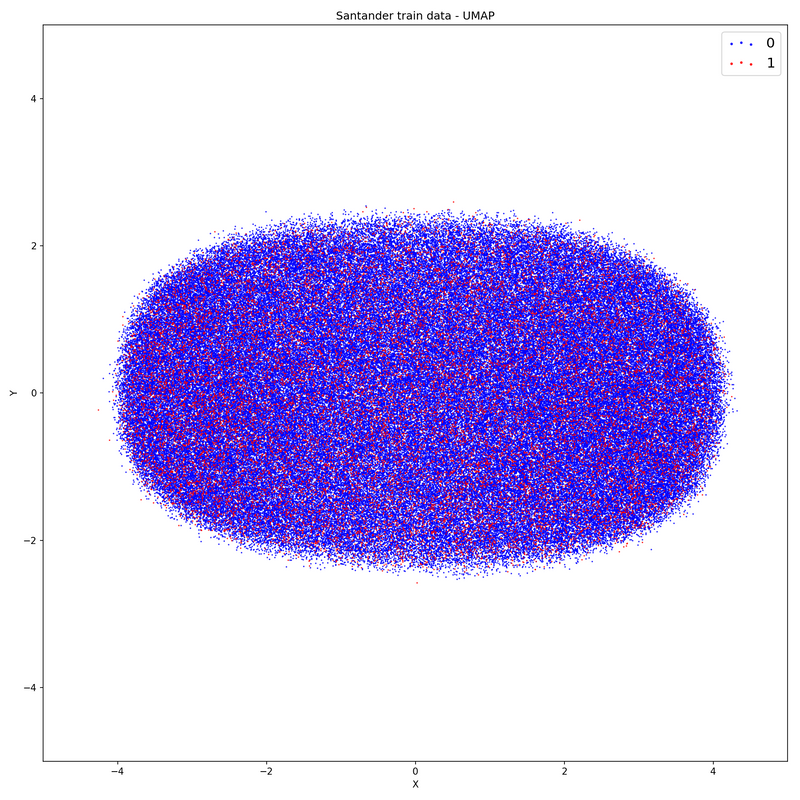

Thông thường, oversampling hay undersampling sẽ có hiệu quả cao khi data có một sự phân chia nào đó đối với các label. Nên khi ta oversampling hay undersampling thì ta đang cố giúp model nhận diện rõ hơn sự phân biệt đó để tăng sự chính xác. 

Còn như data của bài này ta thấy 2 label 0 và 1 dàn trải và trộn lẫn đồng đều vào nhau. Việc oversampling hay undersampling sẽ chỉ tạo thêm noise cho data, có thể nó sẽ giúp nhưng sẽ không thực sự hiệu quả.